In [17]:
# импорт библиотек и загрузка датасетов

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as mcolors
import seaborn as sns
from operator import attrgetter

olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv', parse_dates = [3,4,5,6,7])
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv', parse_dates = [4])

In [18]:
# информация о датасете с клиентами

olist_customers_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [19]:
# информация о датасете с заказами
olist_orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [20]:
# информация о товарах в заказах
olist_order_items_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


#### Задача 1. Построить матрицу с когортным анализом retention rate по месяцам.

In [21]:
# проверка на нулевые значения
olist_customers_dataset.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [22]:
# проверка на нулевые значения
olist_orders_dataset.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [23]:
# проверка на нулевые значения
olist_order_items_dataset.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [24]:
# построение матрицы retention rate по данным заказов со статусом "размещен" ("approved"), 
# так как заказы со статусом "доставлен" ("delivered") сужают временной интервал

merged = olist_orders_dataset.merge(olist_customers_dataset, how = 'inner', on = 'customer_id')
merged = merged.dropna()

merged['order_period'] = merged['order_approved_at'].dt.to_period('M')
merged['order_period_day'] = merged['order_approved_at'].dt.to_period('D')

merged['cohort'] = merged.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('M')
merged['cohort_day'] = merged.groupby('customer_unique_id')['order_approved_at'].transform('min').dt.to_period('D')

merged['period_number_month'] = np.floor((merged.order_period_day - merged.cohort_day).apply(attrgetter('n')) / 30)

df_cohort = merged.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003745,NaN,NaN,0.003745,...,0.003745,NaN,0.003745,NaN,0.003745,NaN,0.003745,0.007491,0.003745,0.003745
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002928,NaN,0.005857,0.001464,0.001464,0.002928,0.002928,NaN,NaN,...,0.005857,0.004392,0.002928,NaN,0.002928,0.002928,0.002928,0.001464,NaN,NaN
2017-02,1.0,0.001241,0.001861,0.003722,0.002481,0.001241,0.002481,0.000620,0.00062,0.002481,...,0.003722,0.000620,0.001861,0.001241,0.000620,0.000620,0.001861,NaN,NaN,NaN


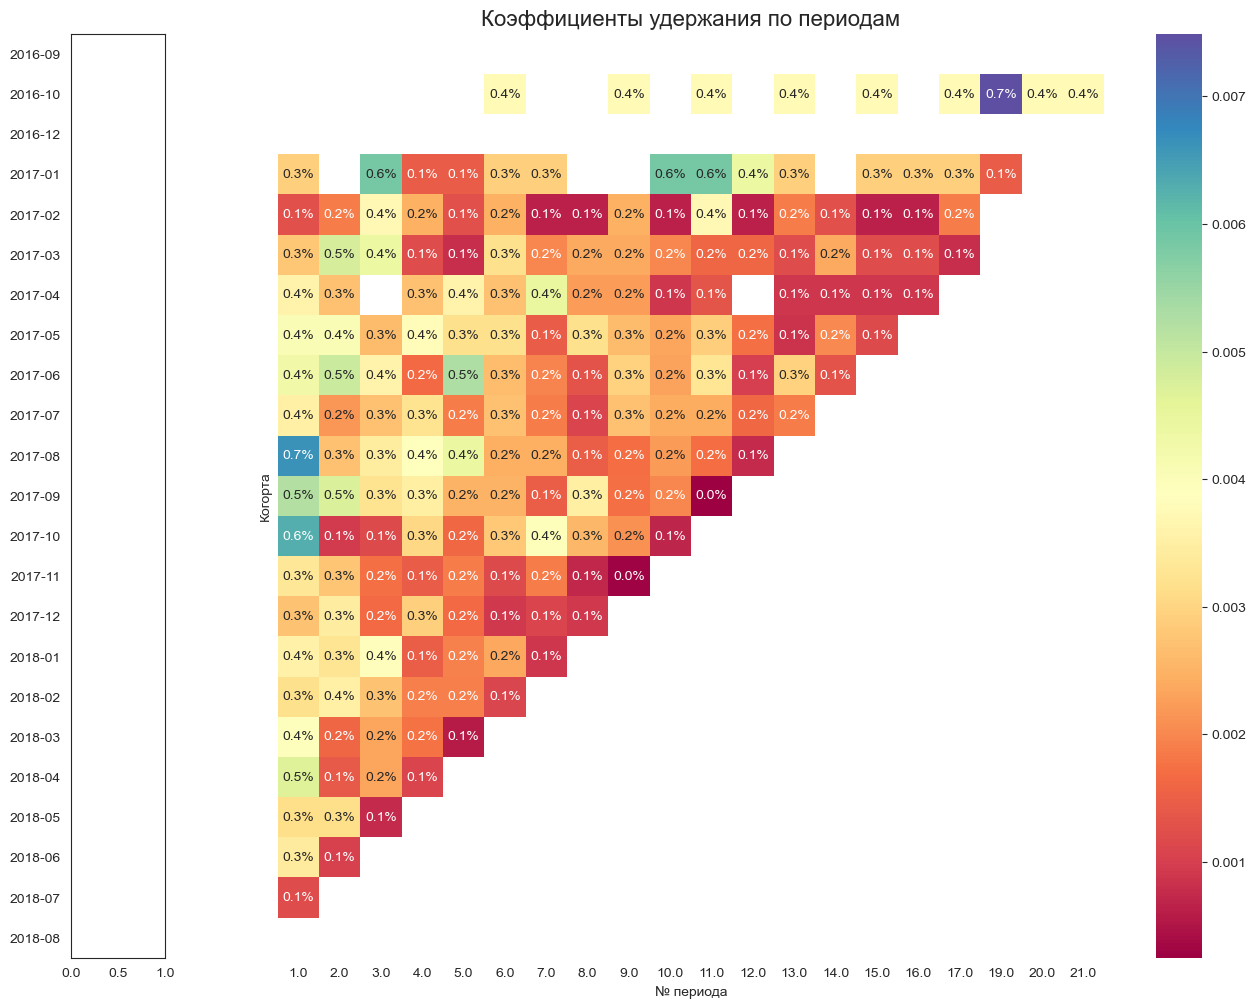

In [25]:
# Строим тепловую карту retention rate
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для retention
    sns.heatmap(retention_matrix.iloc[:, 1:],
                mask=retention_matrix.iloc[:, 1:].isnull(),
                annot=True,
                fmt='.1%',
                cmap='Spectral',
                ax=ax[1])
    ax[1].set_title('Коэффициенты удержания по периодам', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')
    plt.show()

In [26]:
# Ответы на Задание 1:

print(f'Медианный retention rate первого месяца: {round(retention_matrix[1].median(),4)}')
print(f'Когорта с самым высоким retention rate на 3-й месяц: {retention_matrix[3].idxmax()}')

Медианный retention rate первого месяца: 0.0035
Когорта с самым высоким retention rate на 3-й месяц: 2017-01


In [28]:
# проверка retention rate 1 месяца на адекватность
# максимальный retention rate по всем когортам за все периоды
print(f'Максимальный retention rate всех когорт за все время: {round(retention_matrix.iloc[:, 1:].max(), 4)}')
# сердний retention rate по всем когортам за все периоды
print(f'Средний retention rate всех когорт за все время: {round(retention_matrix.iloc[:, 1:].mean().mean(), 4)}')
# Максимальный retention rate свидетельствует о низком желании вернуться в продукт

Максимальный retention rate всех когорт за все время: period_number_month
1.0     0.0066
2.0     0.0049
3.0     0.0059
4.0     0.0039
5.0     0.0053
6.0     0.0037
7.0     0.0045
8.0     0.0035
9.0     0.0037
10.0    0.0059
11.0    0.0059
12.0    0.0044
13.0    0.0037
14.0    0.0024
15.0    0.0037
16.0    0.0029
17.0    0.0037
19.0    0.0075
20.0    0.0037
21.0    0.0037
dtype: float64
Средний retention rate всех когорт за все время: 0.0025


<div class="alert alert-block alert-info">Выводы по Задаче 1:

В продукт после первого использования возвращается менее 1% пользователей. Для интернет-магазина
это слишком низкий показатель.

#### Задача 2. Определить, существует ли product/market fit у маркетплейса, сформулировать гпотезы его отсутствия, предложить фокусные точки для преодоления проблем.

In [ ]:
# Линейный график для определения наличия product/market fit построен по медианным retention rate каждого периода

pmf = retention_matrix.median()
pmf = pmf.fillna(0)

plt.figure(figsize=(10, 5))
plt.plot(pmf, marker='o', linestyle='-', color='b')
plt.title('Динамика медианных retention rate по всем когортам')
plt.xlabel('Период (месяц)')
plt.ylabel('Retention rate')
plt.xticks(pmf.index)
plt.grid()
plt.show()

Retention rate продукта вышел на плато, но значение стабильно ниже 1%. Можно было бы говорить о наличии product/market fit, потому что retention rate всё ещё выше нуля, но для интернет-магазина приемлемым уровнем считается диапазон 20-30%, значит - более верный вывод: PMF отсутствует.

Возможные причины непопулярности продукта: <br>
1) Слабое географическое покрытие доставки <br>
2) Недоступность товаров для заказа и отмена подтвержденных заказов<br>
3) Неудобство платежей <br>
4) Опоздание доставок <br>
5) Долгая доставка

In [ ]:
# Гипотеза 1: Расчет географического покрытия доставок продукта ('nos'). В Бразилии 26 штатов и 1 город федерального значения, 
# всего 27 федеральных единиц.

nos = olist_customers_dataset['customer_state'].nunique()
print(f'Доставка возможна в {nos} федеральных единиц.')

Вывод по гипотезе 1: Доставка осуществляется во все федеральные единицы Бразилии. Гипотеза 1 отвергается.

In [ ]:
# Гипотеза 2: Расчет количества ('ocug') и доли ('souo') заказов не доставленных по причине недоступности товаров
# 'ao' - общее количество заказов

ao = olist_orders_dataset['order_id'].nunique()
ocug = olist_orders_dataset.query('order_status == "unavailable"').shape[0]
souo = round(ocug / ao * 100, 2)
print(f'Всего сделано {ao} уникальных заказов.')
print(f'Отмененных по причине недоступности товаров: {ocug} заказов.')
print(f'Доля отмененных заказов: {souo}%')


Вывод по гипотезе 2: содной стороны, 609 отмененных из-за недоступности товаров заказов - это много, клиенты могут выразить протест уходом из продукта. С другой стороны, их доля менее 1%. Гипотеза 2 может быть рассмотрена с учетом веса остальных гипотез.

In [ ]:
# Гипотеза 3: Определение времени на оплату размещенного заказа. Детальные результаты представлены в минутах.

olist_orders_dataset['approval_length_minutes'] = (
    olist_orders_dataset.order_approved_at - olist_orders_dataset.order_purchase_timestamp
).dt.total_seconds()/60

sorted_ood = olist_orders_dataset['approval_length_minutes'].sort_values()
sorted_ood.describe()

In [ ]:
print(f'Отсутствуют данные об оплате заказа в {sorted_ood.isna().sum()} случаях.')
print(f'Медианное время оплаты заказа {sorted_ood.median()} минут.')
print(f'Не менее 25% заказов имеют время оплаты более {round(874/60, 1)} часов.')

Вывод по гипотезе 3: как правило, на оплату интернет заказа не требуется более 10 минут, даже если это первый заказ, связанный с сохранением данных карты и подтверждением ее валидности. В продукте медианное время оплаты - больше 20 минут, а не менее четверти всех заказов имеют время оплаты более 14 часов. Это может свидетельствовать о неудобной или ненадежной системе оплаты и быть одной из наиболее вероятных причин непопулярности продукта.

In [ ]:
# Гипотеза 4: Определение количества заказов, доставленных позже прогнозной даты ('dd') и их доли ('dds')
# 'ao' - общее количество заказов

dd = olist_orders_dataset.query('order_estimated_delivery_date < order_delivered_customer_date').shape[0]
dds = round(dd / ao * 100, 2)
print(f'Количество заказов, доставленных позже обещанной даты: {dd}.')
print(f'Доля таких заказов: {dds}%.')

In [ ]:
# Гипотеза 5: Определение общего времени доставки в деталях. Детальные результаты представлены в днях.

olist_orders_dataset['delivery_time'] = (
olist_orders_dataset.order_delivered_customer_date - olist_orders_dataset.order_purchase_timestamp
).dt.total_seconds()/86400
olist_orders_dataset['delivery_time'].describe()

In [ ]:
# Объединение датасетов по клиентам и заказам для анализа времени доставки и количества заказов по федеральным единицам. 
# Финальный датасет отсортирован по среднему времени доставки в днях.
# Добавлены колонки с процентыми весами времени доставки и количества заказов для каждой федеральной единицы.

ocd_ood = olist_customers_dataset.merge(olist_orders_dataset, on = 'customer_id')

ocd_ood = ocd_ood.rename(columns = {'order_id' : 'quantity_of_orders'})

ocd_ood_delivery = ocd_ood.groupby('customer_state') \
.agg({'delivery_time': 'mean','quantity_of_orders':'count'}) \
.reset_index() \
.sort_values('delivery_time', ascending = False)

ocd_ood_delivery = ocd_ood_delivery.rename(columns = {'delivery_time':'mean_delivery_time'})

ocd_ood_delivery['dt_percent'] = ((ocd_ood_delivery.mean_delivery_time / ocd_ood_delivery.mean_delivery_time.sum() )*100).round(2)
ocd_ood_delivery['qo_percent'] = ((ocd_ood_delivery.quantity_of_orders / ocd_ood_delivery.quantity_of_orders.sum() )*100).round(2)

ocd_ood_delivery = ocd_ood_delivery.rename(columns = {'dt_percent':'mdt_percent'})

ocd_ood_delivery


In [ ]:
# Построение диаграммы для визуализации зависимости времени доставки и количества заказов от федеральной единицы.

ocd_ood_delivery_diag = ocd_ood_delivery[['customer_state', 'mdt_percent', 'qo_percent']].set_index('customer_state')

ocd_ood_delivery_diag.plot.bar()

Выводы для гипотез 4 и 5: <br>

Интернет-магазином пользуются, в первую очередь, для удобства. Кроме широты ассортимента, качества и цен товаров, время доставки и точное его соблюдение - один из самых важных факторов.  Доля заказов с превышением времени доставки против прогнозного достигает почти 8% и может быть очень вероятной причиной отказа от дальнейших покупок. Кроме того, по известному маркетинговому закону, негативные оценки распространяются среди пользователей лучше позитивных ("сарафанное радио"), это приводит к низкому числу новых клиентов. <br>

Абсолютное время доставки сильно варьируется в зависимости от штата, но даже сейчас видно, что с ускорением доставки количество заказов возрастает. У нас нет подтверждения в датасете, но SP (Sao Paolo) - самый населенный город-штат в Бразилии и, вероятно, штаб-квартира исследуемого продукта и можно не брать его в расчет, но картина в целом не изменится.

<div class="alert alert-block alert-info">Выводы по задаче 2: <br>
Product/market fit отсутствует, пользователи почти не возвращаются в продукт о чем свидетельствует крайне низкий retention rate. Возможные  причины: сложность оплаты, недоступность товаров, долгая доставка, нарушение прогнозных сроков доставки. Рекомендация продакт-менеджеру: после анализа метрик сконцентрироваться на исправлении недочетов и повышении retention rate.

#### Задача 3. Определить 5 основных метрик для изменения, чтобы максимизировать прибыль компании. 

Данных о расходах нет, поэтому ниже предлагаются именно такие метрики. :<br>
    1) Рост объёма продаж маркетплейса - Revenue (Выручка в месяц).<br>
    2) Объем аудитории, которой продукт доставляет ценность - MAU (Количество активных пользователей в месяц).<br>
    3) Заинтересованность новых клиентов в продукте - Количество новых клиентов ежемесячно (NMU).<br>
    4) Вовлеченность клиента в продолжение использования продукта - Retention rate (Коэффициент удержания).<br>
    5) Денежное выражение вовлеченности клиента - ARPU (Среднемесячный доход на клиента).

In [ ]:
# Объединение всех датасетов
full_df = olist_customers_dataset.merge(olist_orders_dataset, on = 'customer_id') \
.merge(olist_order_items_dataset, on = 'order_id')

full_df.info()

In [ ]:
# Расчет ежемесячного GMV:
# Добавление столбца 'order_purchase_month' для дальнейшей группировки

full_df['order_purchase_month'] = full_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Группировка по месяцам и суммирование покупок ('price')

gmv = full_df.groupby('order_purchase_month').agg(gmv = ('price', 'sum')).reset_index()

# Визуализация GMV 

plt.figure(figsize=(10,5)) 
sns.lineplot(data=gmv, x = 'order_purchase_month', y='gmv')
plt.title('GMV по месяцам')
plt.xlabel('Месяц покупки')
plt.ylabel('GMV (выручка, млн)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Вывод по GMV: после пикового значения в ноябре 2017 выручка больше не росла.

In [ ]:
# Расчет MAU с визуализацией

mau = full_df.groupby('order_purchase_month')['customer_unique_id'].nunique().reset_index()
mau = mau.rename(columns = {'customer_unique_id':'mau'})

plt.figure(figsize=(10,5)) 
sns.lineplot(data=mau, x = 'order_purchase_month', y='mau')
plt.title('MAU по месяцам')
plt.xlabel('Месяц покупки')
plt.ylabel('MAU (количество)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Вывод по MAU: после пикового значения в ноябре 2017 ежемесячное количество пользователей больше не росло.

In [ ]:
# Расчет ежемесячного количества новых пользователей ('nmu') с визуализацией

full_df['first_purchase_month'] = full_df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min') \
.dt.to_period('M') \
.astype(str)

nmu = full_df.groupby('first_purchase_month')['customer_unique_id'].nunique().reset_index()
nmu = nmu.rename(columns = {'customer_unique_id':'nmu'})

plt.figure(figsize=(10,5)) 
sns.lineplot(data = nmu, x = 'first_purchase_month', y='nmu')
plt.title('NMU по месяцам')
plt.xlabel('Месяц первой покупки')
plt.ylabel('NMU (количество)')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
# Вычисление разницы между MAU и NMU, чтобы исключить идентичность данных.
mau_nmu = mau['mau'] - nmu['nmu'] 
mau_nmu

Вывод по NMU: после пикового значения в ноябре 2017 ежемесячное количество новых пользователей больше не росло. Динамика разницы между MAU и NMU положительная, количество возвращающихся пользователей возрастает, хотя таких пользователей очень мало (низкий retention rate).

<div class="alert alert-block alert-warning">Диаграмма медианного Retention rate (метрики 4) и выводы по метрике приведены в задаче 2.

In [ ]:
# Расчет ARPU c визуализацией

arpu = full_df.groupby(['order_purchase_month', 'customer_unique_id']).agg(order_sum = ('price', 'sum')).reset_index()
arpu = arpu.groupby('order_purchase_month').agg(arpu = ('order_sum', 'mean')).reset_index()

plt.figure(figsize=(10,5)) 
sns.lineplot(data=arpu, x = 'order_purchase_month', y='arpu')
plt.title('ARPU по месяцам')
plt.xlabel('Месяц покупки')
plt.ylabel('ARPU')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Вывод по ARPU: средний чек на пользователя имеет отрицательный тренд.

<div class="alert alert-block alert-info">Выводы по зданию 4: <br>
Все метрики показывают очень похожую динамику, если изучать только графики, метрики можно спутать. После ноября 2017 года рост всех метрик остановился. Динамика ARPU отрицательная (это может быть связано с понижением цен - первым инструментом, к которому прибегают в торговле для удержания и возвращения клиентов). Отсутствуют данные о расходах, невозможно посчитать прибыльность продукта, LTV и сходимость unit-экономики. 

Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Продуктовая команда выставила Ease и Confidence, нужно расчитать Impact для каждой гипоотезы:<br>

Если исправить баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится.Считаем, что мы таким образом избавимся от всех отмен. Confidence - 8, Ease - 6.	
												
Если сократить время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. Confidence - 10, Ease - 4.		

Если создать новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов. Confidence - 5, Ease - 9.

Для расчёта Impact возьмем данные с июня 2017 года и будем считать, что конверсия в повторный заказ равна величине медианного retention 1-го месяца.

Для перевода метрики в Impact воспользуйтесь следующей шкалой:

Impact и значение метрики: 1 (0-50), 2 (51-150), 3 (151-350), 4 (351-750), 5 (751-1550), 6 (1551-3150), 7 (3151-6350), 8 (6351-12750), 9 (12751-25550), 10 (25551-51150).

In [ ]:
# Расчет Impact для трех гипотез по данным с '2017-06-01'
# Единица - количество вновь размещенных заказов
# 'nocr' - конверсия в повторный заказ
# 'h1i' - impact первой гипотезы, h1c' - confidence первой гипотезы, 'h1e' - ease первой гипотезы. Далее - по аналогии.

impact_df = full_df.query('order_purchase_timestamp >= "2017-06-01 00:00:00"') # датафрейм для ICE, отфильтрованный по дате


nocr = 0.0035

h1c = 8
h1e = 6

h2c = 10
h2e = 4

h3c = 5
h3e = 9

# функция для перевода данных в значение шкалы Impact
def impact_score(x):
    if x <=50:
        score = 1;
    elif x <=150:
        score = 2;
    elif x <=350:
        score = 3;
    elif x <=750:
        score = 4;
    elif x <=1550:
        score = 5;
    elif x <=3150:
        score = 6;
    elif x <=6350:
        score = 7;
    elif x <=12750:
        score = 8;        
    elif x <=25550:
        score = 9;
    else:
        score = 10
    
    return(score)


In [ ]:
# Гипотеза 1: все отмененные заказы ('unavailable' и 'canceled') будут выполнены 
# 'quco' - общее количество отмененных заказов, которое станет новыми заказами
# Конверсия не применяется, так как все отмененные заказы становятся действительными

quco = impact_df.query('order_status in ["unavailable", "canceled"]')['order_id'].nunique()
h1i = impact_score(quco)
h1_ice = h1i * h1c * h1e
print(f'ICE для первой гипотезы: {h1_ice}')

In [ ]:
# Гипотеза 2: часть заказов, поступивших с задержкой (позже обещанной даты), конвертировались в новые заказы
# после устранения задержек 
# 'ldo' - заказы с опозданием, доставленные после прогнозной даты
# Число повторных заказов 'ldo * nocr'

ldo = impact_df.query('order_delivered_customer_date > order_estimated_delivery_date')['order_id'].nunique()
ldo_cr = ldo * nocr
h2i = impact_score(ldo_cr)
h2_ice = h2i * h2c * h2e
print(f'ICE для второй гипотезы: {h2_ice}')


In [ ]:
# Гипотеза 3: часть заказов, процесс оплаты которых был слишком долгим, разместили повторно, после исправления бага 
# 'almo' - заказы клиентов с проблемами оплаты (более медианной продолжительности)
# Число повторных заказов 'almo * nocr'
almo = impact_df.query('approval_length_minutes > 20.6')['order_id'].nunique()
almo_cr = almo * nocr
h3i = impact_score(almo_cr)
h3_ice = h3i * h3c * h3e
print(f'ICE для третьей гипотезы: {h3_ice}')


In [ ]:
# Информация по датасету отмененных заказов (Гипотеза 1) для выявления возможных противоречий
quco_info = impact_df.query('order_status in ["unavailable", "canceled"]')
quco_info.info()
# видно, что для отмененных заказов отсутствует дата доставки до клиента, но присутствует подтверждение заказа и его оплата

<div class="alert alert-block alert-info">Вывод по задаче 4:<br>
Приоритетной считаем гипотезу 1, набравшую наибольший ICE. Результат получен вследствие очень низкого retention rate (0.0035), который используется в качестве коэффициента конверсии, из-за чего количество повторных заказов при исправлении процессинга доставки или оплаты будет меньше, чем количество просто неотмененных заказов. <br>
Отмененные заказы могут быть более серьезной проблемой, чем кажется. По информации из датасета с отмененными заказами, они сначала подтверждаются и оплачиваются (!), им назначается дата доставки клиенту, а потом они отменяются компанией. За рамками системы остается ответ на вопрос о времени оповещения об отмене и процессе, и времени возврата денег, которые так же болезненны для клиента.

#### Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

<div class="alert alert-block alert-info">Сформулированные метрики для продакт-менеджера для проведения A/B-теста:<br><br>

Целевая -<br><br>
    
Доля доставленных заказов от числа оплаченных заказов: чувствительная, достоверная, интерпретируемая. Отмененные заказы не доставляются, среднее время доставки - 12 дней. Рост метрики будет однозначным сигналом снижения отмен и его можно увидеть очень быстро.<br><br>

Прокси - <br><br>

Среднее число заказов на пользователя: чувствительная, достоверная, интерпретируемая. Если среднее время доставки - 12 дней, можно увидеть повторные заказы в течение отчетного месяца.<br><br> 

ARPU: чувствительная, достоверная, интерпретируемая. Из-за высокой скорости повторных заказов рост ARPU будет виден в течение отчетного месяца.<br><br>

Guardrail (барьерная) -<br><br>

Доля отмененных заказов (она же доля недоставленных): чувствительная, достоверная, интерпретируемая. Среднее время отмены равно среднему времени доставки, рост метрики в течение отчетного месяца будет однозначным сигналом увеличения числа отмен.

#### Задача 6: Формализовать задачу всего проекта, сформулировать выводы о проделанной работе, внести предожения по улучшению продукта.   

<div class="alert alert-block alert-info">Формализация задачи:<br><br>
Основная проблема продукта – выручка магазина вышла на плато, необходимо найти и устранить причины стагнации посредством анализа основных метрик, выдвижения гипотез, их приоритизации и влияния на ключевые метрики.<br><br>
Выводы по пункту 1:<br><br>
Проведен когортный анализ пользователей и рассчитан коэффициент удержания (retention rate). Наблюдается крайне высокий отток клиентов, в продукт возвращается менее 4 человек из тысячи при медианном коэффициенте удержания первого месяца 0.0035. Среднее значение retention rate по всем когортам и периодам 0.0025, что еще хуже. <br><br>
Заключение: Необходимо предпринимать меры по возвращению клиентов в продукт.<br><br>
Выводы по пункту 2:<br><br>
Построен график медианных retention rate по всем когортам и периодам. Коэффициент удержания вышел на плато, но значения крайне малы, не превышают 1%. Формально у продукта наблюдается product/market fit, но при негласном приемлемом среднем уровне retention rate в 20-30% для интернет-магазина, необходимо отвергнуть этот вывод. <br><br>
Заключение: product/market fit у продукта отсутствует.<br><br>
Предложены 5 гипотез с возможными причинами отсутствия product/market fit: Слабое географическое покрытие доставки; Отмена заказов по любой причине (включая недоступность товаров); Неудобный процессинг оплаты; Опоздание доставок; Долгое время доставки. Приоритизация 3 гипотез: отмены, оплаты и задержки будет проведена в рамках фреймворка ICE в блоке 4. <br><br>
Заключение: Необходимо выбрать основные метрики, на которые нужно повлиять для исправления ситуации. Для этого выделены три наиболее вероятные причины низкого product/market fit, для последующей приоритизации одной из них и определения метрик.<br><br>
Выводы по пункту 3:<br><br>
Для дальнейшего анализа предложены 5 метрик, исходя из доступных данных:<br><br>
1) Рост объёма продаж маркетплейса - Revenue (Выручка в месяц).<br>
2) Объем аудитории, которой продукт доставляет ценность - MAU (Количество активных пользователей в месяц).<br>
3) Заинтересованность новых клиентов в продукте - Количество новых клиентов ежемесячно (NMU).<br>
4) Вовлеченность клиента в продолжение использования продукта - Retention rate (Коэффициент удержания).<br>
5) Денежное выражение вовлеченности клиента - ARPU (Среднемесячный доход на клиента).<br><br>
В итоге все метрики показывают очень похожую динамику, если изучать только графики, метрики можно спутать. После ноября 2017 года рост всех метрик остановился. Динамика ARPU отрицательная (это может быть связано с понижением цен - первым инструментом, к которому прибегают в торговле для удержания и возвращения клиентов). Отсутствуют данные о расходах, невозможно посчитать прибыльность продукта, LTV и сходимость unit-экономики. <br><br>
Заключение: низкий retention rate негативно влияет на все основные метрики маркетплейса. Его влияние настолько велико, что динамика метрик идентична, они стагнируют после ноября 2017 года, а среднемесячный доход на клиента падает.<br><br>
Выводы по пункту 4:<br><br>
Для приоритизации выбраны следующие гипотезы:<br><br>
1)	Проблема в отмене заказов и нужно избавляться от бага в системе процессинга заказов, тогда пользователи перестанут отменять заказы.<br>
2)	Проблема в опоздании доставки, если ее решить, клиенты будут размещать повторные заказы.<br>
3)	Проблема в способе оплаты, если ее решить, то клиенты не будут испытывать трудности при оформлении заказа и размещать повторные.<br><br>
По фреймворку ICE наибольший результат набрала гипотеза 1. Правда, успех был обеспечен вследствие очень низкого retention rate (0.0035), который используется в качестве коэффициента конверсии, из-за чего количество повторных заказов при исправлении процессинга доставки или оплаты будет меньше, чем количество просто неотмененных заказов.<br><br>
Тем не менее, отмененные заказы могут быть более серьезной проблемой, чем кажется. По информации из датасета с отмененными заказами, они сначала подтверждаются и оплачиваются (!), им назначается дата доставки клиенту, а потом они отменяются компанией. За рамками системы остается ответ на вопрос о времени оповещения об отмене и процессе, и времени возврата денег, которые так же болезненны для клиента.<br><br>
Заключение: наиболее высокое число повторных заказов можно получить, избавившись от отмен, которые появляются вследствие багов при процессинге. Эту задачу нужно поставить разработчикам.<br><br>
Выводы по пункту 5:<br><br>
Исправление процессинга оформления заказа должно повлиять на достоверные, чувствительные и интерпретируемые метрики, непосредственно связанные с отменами:<br><br>
Целевая -<br>
Доля доставленных заказов от числа оплаченных заказов: чувствительная, достоверная, интерпретируемая. Отмененные заказы не доставляются, среднее время доставки - 12 дней. Рост метрики будет однозначным сигналом снижения отмен и его можно увидеть очень быстро.<br><br>
Прокси -<br>
Среднее число заказов на пользователя: чувствительная, достоверная, интерпретируемая. Если среднее время доставки - 12 дней, можно увидеть повторные заказы в течение отчетного месяца.<br>
ARPU: чувствительная, достоверная, интерпретируемая. Из-за высокой скорости повторных заказов рост ARPU будет виден в течение отчетного месяца.<br><br>
Guardrail (барьерная) -<br>
Доля отмененных заказов (она же доля недоставленных): чувствительная, достоверная, интерпретируемая. Среднее время отмены равно среднему времени доставки, рост метрики в течение отчетного месяца будет однозначным сигналом увеличения числа отмен.<br><br>
Заключение: необходимо сконцентрироваться на меньшем количестве метрик, которые не зависят от внешней среды и имеют высокую скорость и интерпретируемость, и описывают происходящее с отменой или успешным прохождением заказа. Это позволит сократить время на А/В-тестирование и получить достоверные результаты.<br><br>
Общие выводы по итогу исследования:<br><br>
Данные позволили провести минимально необходимый анализ для формирования гипотез по улучшению продукта. Выявлены метрики и их динамика, приоритизированы гипотезы, среди которых основной выбрана версия сокращения отмены заказов и работы над исправлением процессинга заказов, что позволит в короткой перспективе отслеживать негативные и позитивные изменения в долях доставленных и отмененных заказов, среднем количестве заказов и ARPU. Это позволит влиять на retention rate, который в свою очередь будет влиять на указанные метрики.<br><br>
Однако, отсутствие данных по расходам не позволяет провести исследование unit-экономики, поскольку даже при внедрении рекомендованных изменений итоговый результат может принести убытки в случае превышения расходов по привлечению клиента над доходами, полученными с того же клиента.<br><br>
Рекомендации по продукту.<br><br>
Собранные данные позволяют провести только поверхностный анализ, поэтому необходимо:<br>
Увеличить широту собираемой информации (детализация по клиентам – возраст, пол, используемые платформы; все возможные виды расходов, прибыль, способы оплаты, реклама, проведение акций, обратная связь от клиентов, …) и предоставлять для анализа данные по конкурентам для benchmark по обещанному времени доставки и сроках доставки, способах оплаты, широте ассортимента, информационной поддержке, качестве контента (карточек товара), ценах и т.п. <br>
После детальных исследований новых данных стоит провести RFM-анализ и проверить сходимость unit-экономики.<br>
Провести сбор данных по удовлетворенности клиентов: сроками доставки, способами оплаты, товарами, сервисом, скоростью работы приложения, удобством интерфейса.




